# Dense Neural Networks

In this notebook, I will be implementing a dense neural network, specifically the Deep Neural Multilayer Perceptron (MLP).

For more details about the algorithm, check out the README of this subdirectory, [here](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/dense_neural_network/README.md).

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Using scikit-learn

I will be first be using `MLPClassifier` from the scikit-learn library to implement the dense neural multilayer perceptron.

### Model 1: Species Classification Using 2 Predictors (Wing & Tail Length)

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [3]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing", "Tail"]]
y = hawks["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

The first question in fitting the `MLPClassifier` is the optimal value for the hyperparameters. To determine the best value for the hyperparameter `hidden_layer_sizes`, I will iterate over a range of number of neurons and find the value that results in the highest accuracy. Keep in mind that while increasing the number of hidden layers and/or the number of neurons in each layer can increase the capacity of the network, allowing for more complex relationships in the data to be modeled, increasing the number of neurons can also lead to overfitting, especially if the model has a large number of parameters relative to the size of the training data.

In [4]:
def plot_neuron_accuracies(X_train, y_train):
    """
    Plot the accuracies for neural networks of different numbers of neurons in the ith hidden layer
    to determine the optimal parameter for hidden_layer_sizes to proceed with.
    """
    possible_n = range(1, 10)
    accuracies = []
    for n_layers in possible_n:
        mlp = MLPClassifier(hidden_layer_sizes=(n_layers,), max_iter = 5000, random_state = 42)
        mlp.fit(X_train, y_train)
        accuracies.append(mlp.score(X_train, y_train))
    
    plt.figure(figsize = (7, 5))
    plt.plot(possible_n, accuracies, color = 'red', marker = "o")
    plt.xlabel("Number of neurons in hidden layer", fontsize = 12)
    plt.ylabel("Training accuracy", fontsize = 12)
    plt.xticks(possible_n)

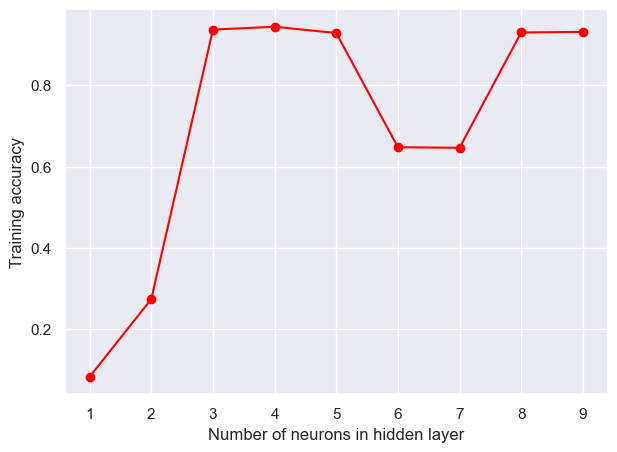

In [5]:
plot_neuron_accuracies(X_train, y_train)

Accuracy is highest at 3 neurons, and increasing neurons beyond this point only increases training accuracy marginally at the most. So, I will proceed with 3 as my hyperparameter.

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(3,), max_iter = 5000, random_state = 42)
mlp.fit(X_train, y_train)

print("Training accuracy: ", mlp.score(X_train, y_train))
print("Testing accuracy: ", mlp.score(X_test, y_test))

Training accuracy:  0.9367977528089888
Testing accuracy:  0.9497206703910615


In [7]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CH       1.00      0.38      0.56        13
          RT       0.98      1.00      0.99       106
          SS       0.89      0.98      0.94        60

    accuracy                           0.95       179
   macro avg       0.96      0.79      0.83       179
weighted avg       0.95      0.95      0.94       179



Overall, the MLP performs well, but recall for the Cooper's hawk (CH) is extremely low. By the interpretation of recall, out of all the hawks in the testing set that actually were a Cooper's hawk, the model predicted the species correctly for 38% of these hawks. This is evident in the confusion matrix.

In [8]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Confusion Matrix', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

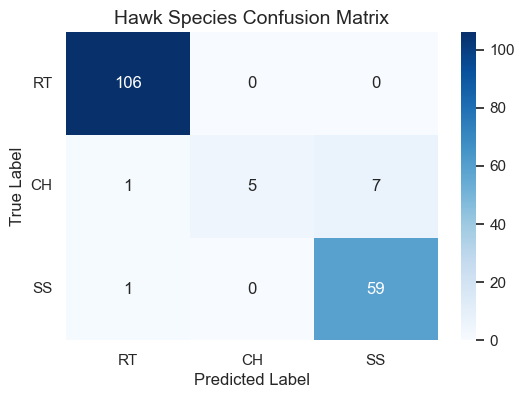

In [9]:
plot_hawk_confusion_matrix(y_test, y_pred)

There are 13 Cooper's hawks and only 5 of them are classified correctly. For the other hawk species though, the MLP did not have problems correctly predicting their species.

### Model 2: Species Classification Using 5 Predictors

I wonder if I can improve this MLP model by including more predictors. Given the increase in complexity however, it may or may not be worth it.

In [10]:
# Set up new predictors matrix
X2 = hawks[["Wing", "Tail", "Weight", "Culmen", "Hallux"]]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.20, random_state=1)

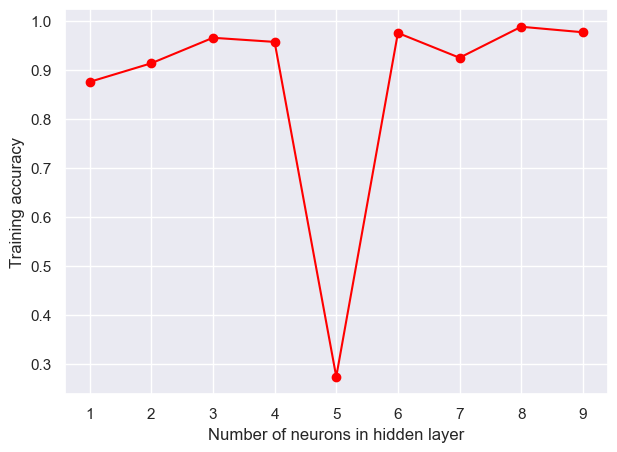

In [11]:
plot_neuron_accuracies(X_train2, y_train2)

Accuracy is highest at 3 neurons, and increasing neurons beyond this point generally decreases training accuracy, or only marginally increases it. So, I will proceed with 3 as my hyperparameter once again.

In [12]:
mlp2 = MLPClassifier(hidden_layer_sizes=(3,), max_iter = 5000, random_state = 42)
mlp2.fit(X_train2, y_train2)

print("Training accuracy: ", mlp2.score(X_train2, y_train2))
print("Testing accuracy: ", mlp2.score(X_test2, y_test2))

Training accuracy:  0.9648876404494382
Testing accuracy:  0.9664804469273743


Training and testing accuracy have slightly improved.

In [13]:
y_pred2 = mlp2.predict(X_test2)
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

          CH       0.83      0.77      0.80        13
          RT       0.98      0.99      0.99       106
          SS       0.97      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.93      0.91      0.92       179
weighted avg       0.97      0.97      0.97       179



Overall, accuracy has increased compared to in model 1. While the recall for Cooper's hawks has gone up significantly, there has been a decrease in the precision for Cooper's hawks.

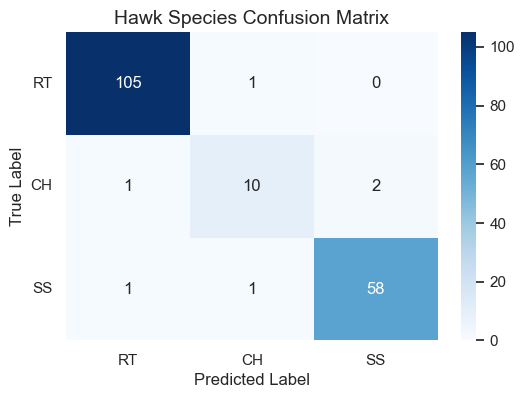

In [14]:
plot_hawk_confusion_matrix(y_test2, y_pred2)

Based on the confusion matrix, it's clear that model 2 is a better model for classifying hawk species. It struggles less with the classification of Cooper's hawks, and there are far fewer of this species to start with. However, because model 2 uses two predictors, it is a more complex model. If we didn't care about identifying Cooper's hawks, perhaps model 1 would be fine. In the context of being able to correctly classify all 3 species though, model 2 is the better MLP model.